# 1 introduction
## 1.1 Background
Movie earnings prediction can be very meaningful in practice. Theaters
may want to determine how to arrange the schedule of movies, or even
shift viewers’ decision in movie selection. There are many factors
that can affect the overall success of a movie such as production
crew, genre, release date, whether it is a sequel and so on.
Statistics and reviews in the first week also say a lot. 
## 1.3 Problem Statement
Our project aims to predict final movie ratings and final box office earnings
based on history data from IMDB and also statistics of Goole Trend. And we are interested to know what
features combined makes a movie more crowd pleasing, award winning, or
even Oscar worthy. We will write our crawler to gather raw data from
IMDB site using python scrapy. The primary features we want to take a
closer look into includes (but not limited to) first week user
reviews, first week box office earnings, actors, directors, movie
keywords etc. We would like to try out several regression and
classification models to optimize training outcome, and use recent
movies as our validation sample to validate our model selection.
## 1.2 Data Description
Our data is composed of 2 parts. The first part is the features we crawled from web pages of IMDB. Below is features we will extracted and used to train our model.

| Feature Name             | Feature Description                                |
|--------------------------|----------------------------------------------------|
| IMDB ID                  | ID of Movie in IMDB                                |
| Awards                   | Awards This Movie Earned                           |
| Box Office               | Total Box Office of the Movie                      |
| First Weekend Box Office | Box Office of the First Weekend After Release Date |
| Country                  | Release Country                                    |
| Release Date             | Release Date of the Movie                          |
| Actors                   | Actors of this movie                               |
| Director                 | Director of this movie                             |
| Genres                   | Genres this movie belongs to                       |
| Meta score               | meta score of the Movie in IMDB                    |
| IMDB rating              | IMDB Rating of the Movie                           |
| Production               | Production Company of This Movie                   |
| Writer                   | Writes of the Movie                                |
| Year                     | Release Year                                       |
| Votes                    | Votes Number of the Movie on IMDB                  |
| Certificate              | Content Rating of the Movie                        |
| Critic Number            | Critic Number of the Movie on IMDB                 |

The second part of the dataset is Google Trend.
<img style="float:center; width:300px" src='./google_trend.png'/>
Above is the format of our google trend data. The first row is the keywords that we use to request the google trend. The rest rows are the date and google trend of this keywork on that date. All the google trend is normalized to 0-100.

# 2 Methods of Extracting Data
The data collection method for model 1 is to use python’s library: Requests and beautiful soup to download and parse the html. We extract many features from the web page of imdb and filter out the movie that have box office to be our target information. We will store the information in CSV format, which will be easy for our model to read.


<img style="float:center; width:800px" src='./model1.png'/>


Because there’s no official API of google trend and it’s hard to use web scrapers to request the information we need, we use third-party API Pytrends to request the trend for us. We want to have the google trend of certain movie within range [one week before release date, one month after release date]. The result will also be stored in CSV format.
<img style="float:center; width:700px" src='./model2.png'/>

# 3 Data Exploration

In [16]:
import pandas as pd
with open('result.csv') as file:
    dataset = pd.read_csv(file)
    
with open('google_index.csv') as file:
    google_index = pd.read_csv(file)

First, we need to load the data from the csv file and store them as dataframes. The data will look like the below.

In [17]:
dataset[:2]

,imdbID,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,...,Writer,Year,imdbRating,imdbVotes,Cumulative Worldwide Gross,Gross USA,Opening Weekend USA,budget,critic number,user review number
0,tt0499549,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000","UK, USA",22 Apr 2010,James Cameron,"Action, Adventure, Fantasy","English, Spanish",83.0,...,James Cameron,2009.0,7.8,"985,058",2.787965e+09,760507625.0,77025481.0,237000000,720.0,3167.0
1,tt1055369,"Shia LaBeouf, Megan Fox, Josh Duhamel, Tyrese ...",Nominated for 1 Oscar. Another 15 wins & 27 no...,"$402,076,689",USA,20 Oct 2009,Michael Bay,"Action, Adventure, Sci-Fi","English, Spanish",35.0,...,"Ehren Kruger, Roberto Orci, Alex Kurtzman",2009.0,6.0,"349,263",8.363037e+08,402111870.0,108966307.0,200000000,373.0,1459.0


In [31]:
google_index[:5]

,title,date_index0,date_index1,date_index10,date_index11,date_index12,date_index13,date_index14,date_index15,date_index16,...,date_index34,date_index35,date_index36,date_index37,date_index4,date_index5,date_index6,date_index7,date_index8,date_index9
0,Avatar,30,33,82,68,67,67,72,82,83,...,38,43,60,63,32,40,49,74,94,100
1,Pirates of the Caribbean: At World's End,17,25,73,50,37,30,32,50,32,...,10,12,8,16,30,27,35,63,86,100
2,Spectre,33,35,57,47,52,43,44,56,57,...,15,18,25,23,31,36,47,73,100,92
3,The Dark Knight Rises,12,14,58,46,46,39,38,43,43,...,11,10,13,14,25,28,38,91,100,83
4,John Carter,19,23,59,44,36,33,36,51,48,...,11,14,14,14,28,35,44,75,100,96


## 3.1 IMDB Ratings and Genres
First, we want to know whether genre is related to IMDB score. We extract the genres and rating of each movie and then store the data in a dict, whose key is genre and value is list of ratings that in this genre.

We then plot IMDB average ratings and genre.





In [19]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

genre_dict = defaultdict(list)

for index in range(len(dataset)):
    genres = dataset.iloc[index]['Genre'].split()
    for genre in genres:
        genre = genre.strip(' ,')
        genre_dict[genre].append(dataset.iloc[index]['imdbRating'])

keys = list(genre_dict.keys())
index = range(len(keys))
mean_ratings = [np.mean(genre_dict[x]) for x in genre_dict]


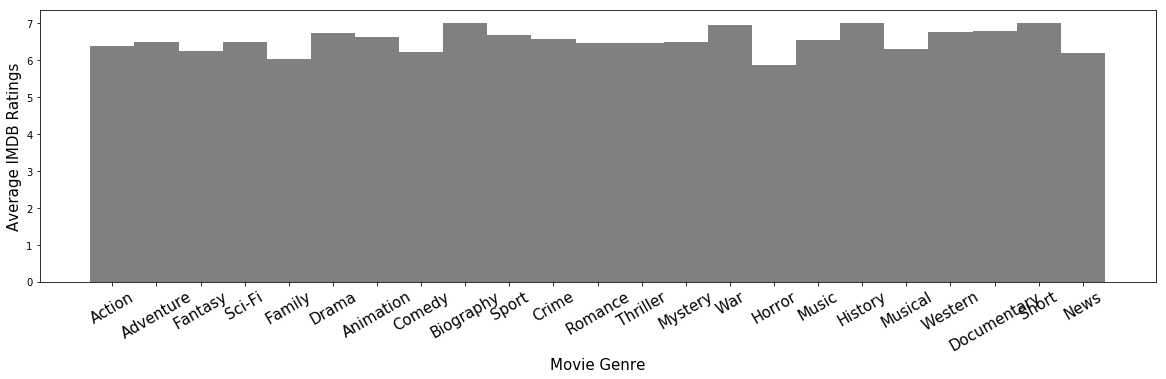

In [22]:
plt.figure(figsize=(20,5))
ax=plt.subplot(111)
plt.bar(index, mean_ratings, width, color="grey")
plt.xticks(index, keys, fontsize=15, rotation=30)
plt.ylabel('Average IMDB Ratings',fontsize=15)
ax.set_xlabel("Movie Genre",fontsize=15)
plt.show()

## 3.2 Histogram of Movie Released
In this Sub-Section, we want to analyze number of movie that was released in each year. As we can see in below chart, our dataset doesn't contain enough data point. Because in common sense, the movie released in each movie should in a trend of increase.


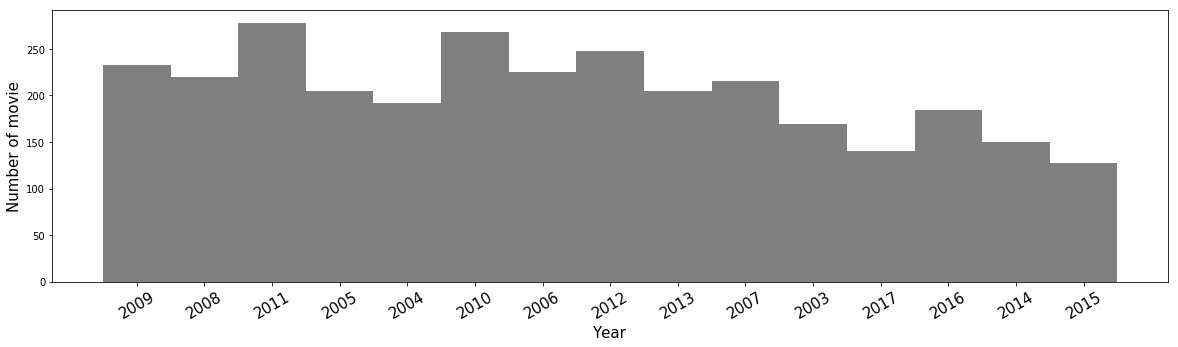

In [62]:
from collections import Counter
year_list = [str(int(x)) for x in dataset['Year']]
years = Counter(year_list)
keys = years.keys()
values = years.values()
index = range(len(keys))
plt.figure(figsize=(20,5))
ax=plt.subplot(111)
plt.bar(index, values, width, color="grey")
plt.xticks(index, keys, fontsize=15, rotation=30)
plt.ylabel('Number of movie',fontsize=15)
ax.set_xlabel("Year",fontsize=15)
plt.show()

## 3.3 Histogram of Top 20 Total Gross of Each Director

In [60]:
director_gross = defaultdict(int)
for index in range(len(dataset)):
    director = dataset.iloc[index]['Director']
    box_office = dataset.iloc[index]['Gross USA']
    director_gross[director] += box_office
director_gross = list(director_gross.items())
director_gross.sort(key = lambda x: x[1], reverse = True)


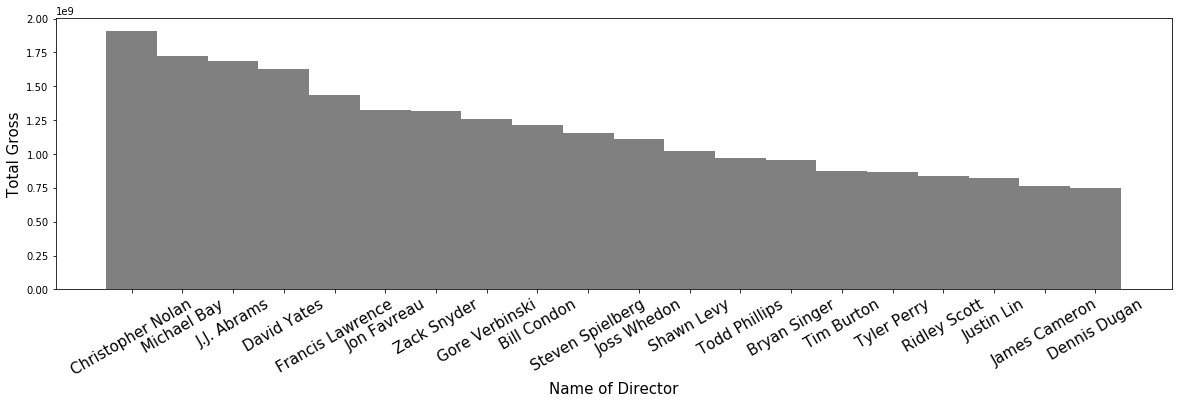

In [61]:
keys = [director_gross[x][0] for x in range(20)]
values = [director_gross[x][1] for x in range(20)]
index = range(len(keys))
plt.figure(figsize=(20,5))
ax=plt.subplot(111)
plt.bar(index, values, width, color="grey")
plt.xticks(index, keys, fontsize=15, rotation=30)
plt.ylabel('Total Gross',fontsize=15)
ax.set_xlabel("Name of Director",fontsize=15)
plt.show()

## 3.4 Opening Weekend Gross Distribution

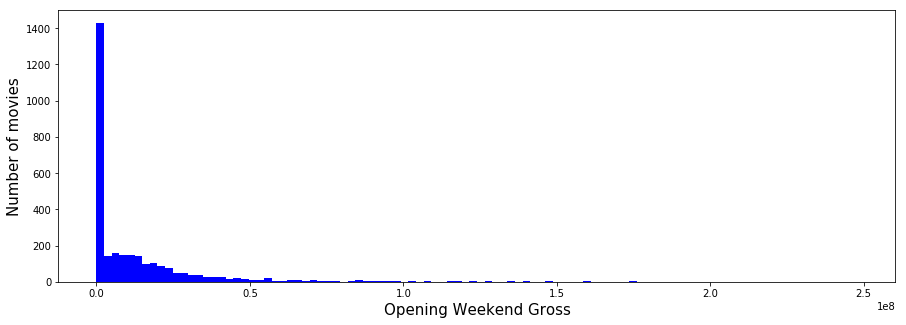

In [58]:
opening_weekend_gross = dataset['Opening Weekend USA'].dropna(axis=0, how='any')
plt.figure(figsize=(15,5))
plt.ylabel('Number of movies',fontsize=15)
plt.xlabel('Opening Weekend Gross',fontsize=15)
n, bins, patches = plt.hist(opening_weekend_gross, bins=100, color="blue")
plt.show()

We can see from the plot, grosses of moives are not scaled, most movies earn little in the first week after released, acutally, 44% of movies get box office less then \$1,000,000. Data is very sparse after \$50,000,000 (6.1% of movies, i.g. 184 movies). Next figure shows every data point in it, for better readibility, we scale out at y axis.

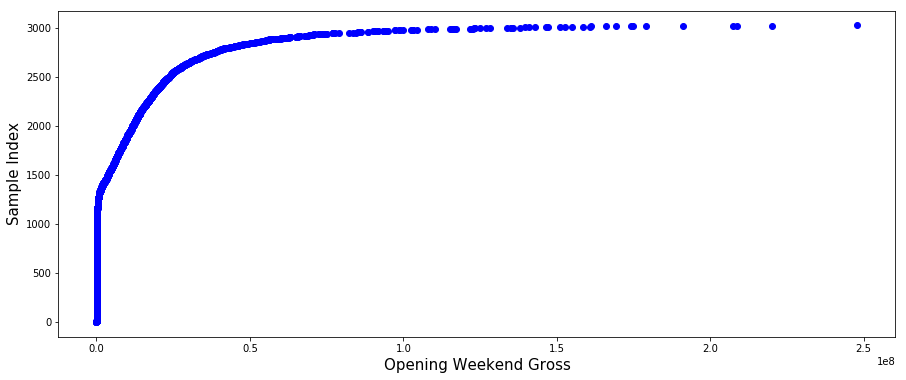

In [68]:
plt.figure(figsize=(15,6))
plt.ylabel('Sample Index',fontsize=15)
plt.xlabel('Opening Weekend Gross',fontsize=15)
plt.scatter(opening_weekend_gross.sort_values(), range(len(opening_weekend_gross)), color="blue")
plt.show()

# 4 Models
## 4.1 Features Extraction
